In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from aps_ai.beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
import beamline34IDC.optimization.common as opt_common
import beamline34IDC.optimization.movers as movers
from aps_ai.beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import glob

In [6]:
%matplotlib inline

In [7]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

18415


In [8]:
base_dir = '/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/'
orig_work_dir = f'{base_dir}/work_directory'
temp_work_dir = f'{base_dir}/tmp_work_dir/{DEFAULT_RANDOM_SEED}'

In [9]:
os.mkdir(temp_work_dir)

In [10]:
dat_files = glob.glob(f'{orig_work_dir}/*.dat')
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [11]:
os.chdir(temp_work_dir)

In [12]:
input_beam_path = "primary_optics_system_beam.dat"

In [ ]:
shutil.rmtree??

In [13]:
move_motors = ['vkb_q', 'hkb_q']

In [14]:
motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
if not os.path.isdir(fig_save_path):
    os.mkdir(fig_save_path)

In [15]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

8.698542372776435e-05


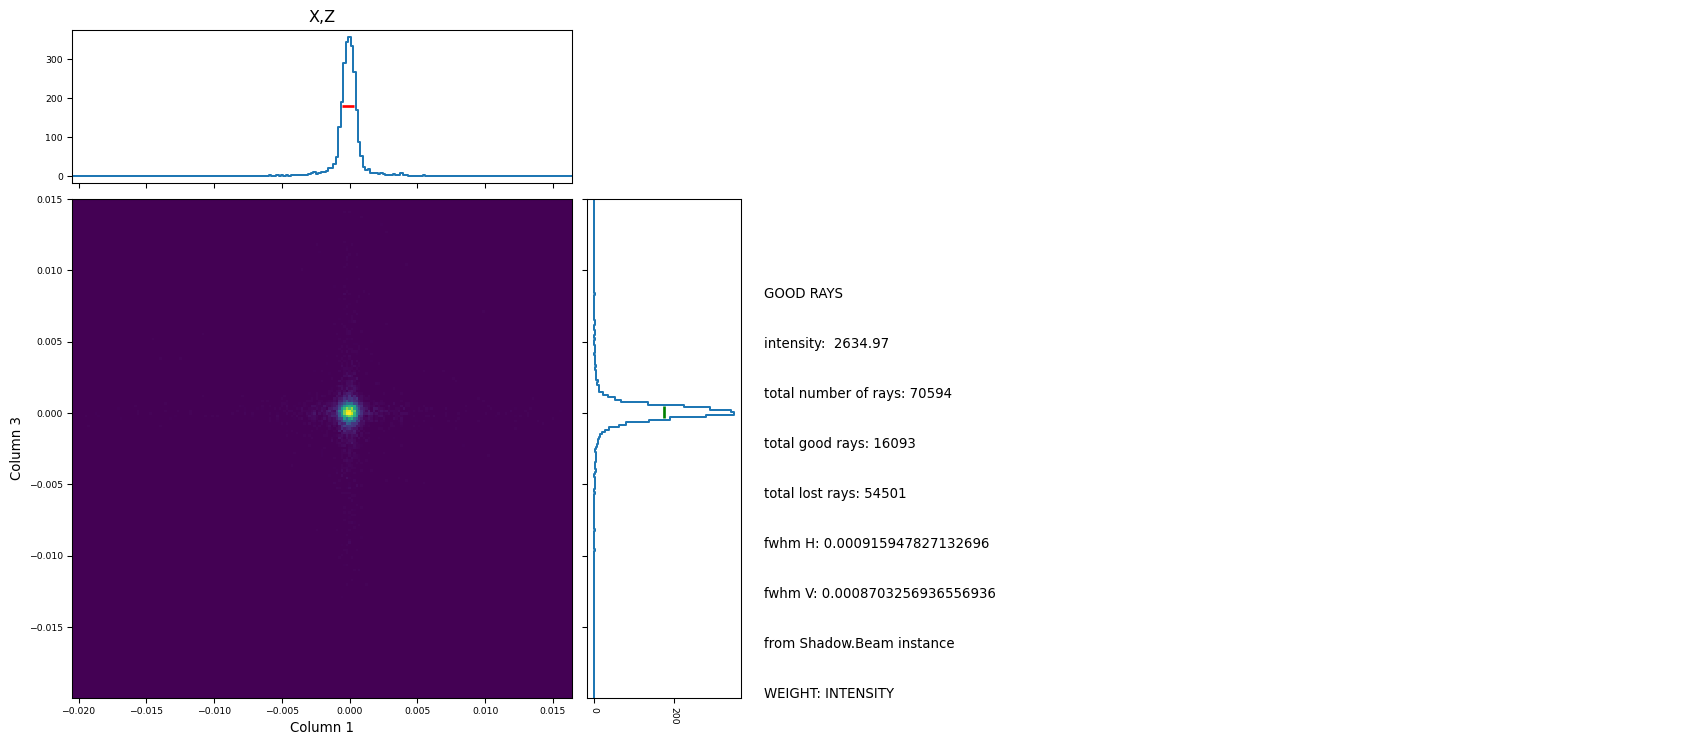

In [16]:
centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system=focusing_system, 
                                                                random_seed=DEFAULT_RANDOM_SEED)
print(centroid)
_ = plot_shadow_beam_spatial_distribution(out_beam)

In [17]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))
print(initial_absolute_positions)

[221. 120.]


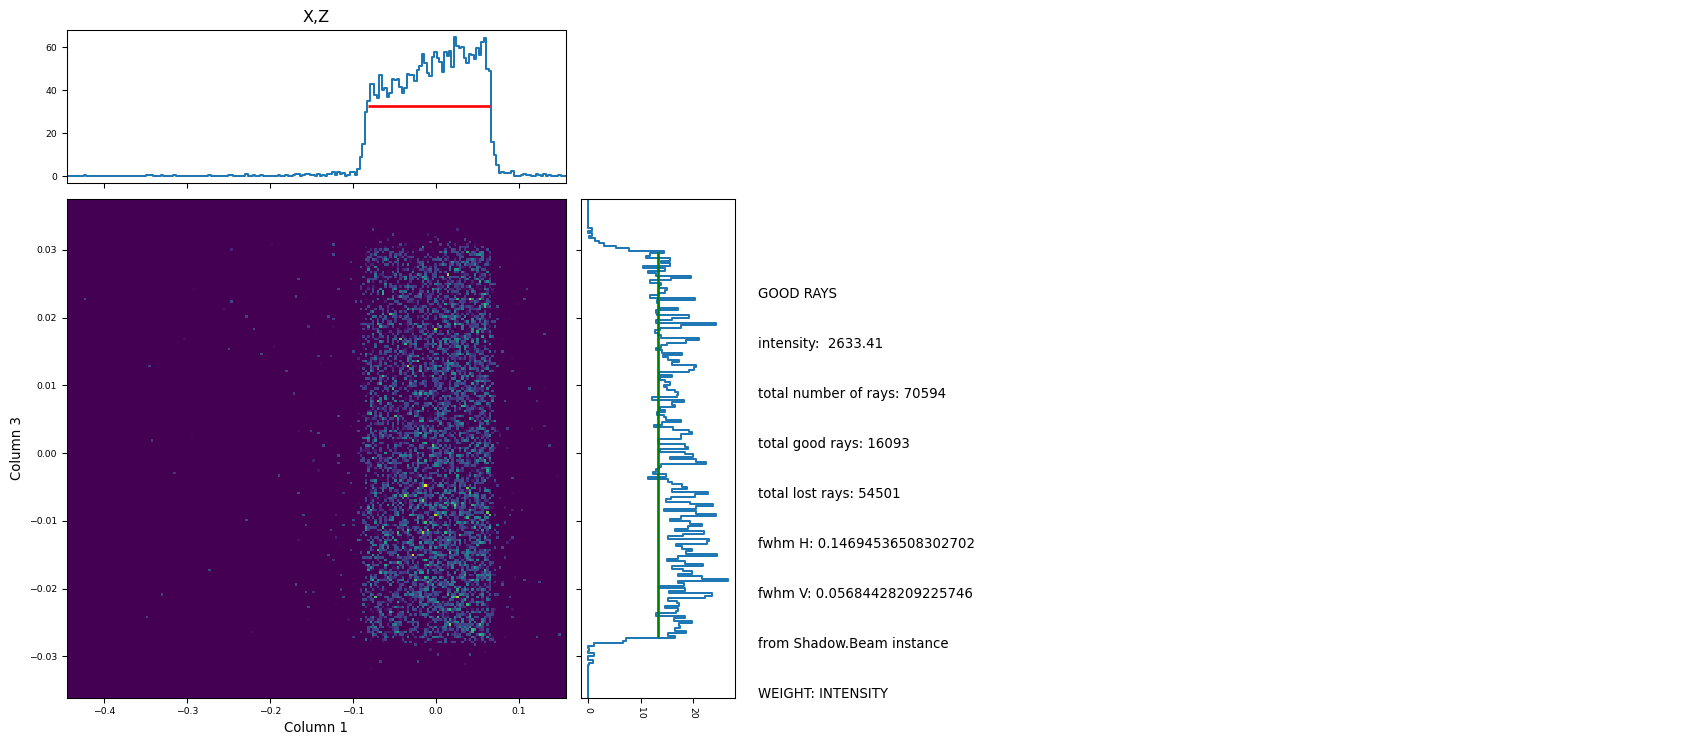

In [15]:
# check positive and negative movement
movers.move_motors(focusing_system, move_motors, [-100, -100], movement='relative')
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)
movers.move_motors(focusing_system, move_motors, initial_absolute_positions, movement='absolute')

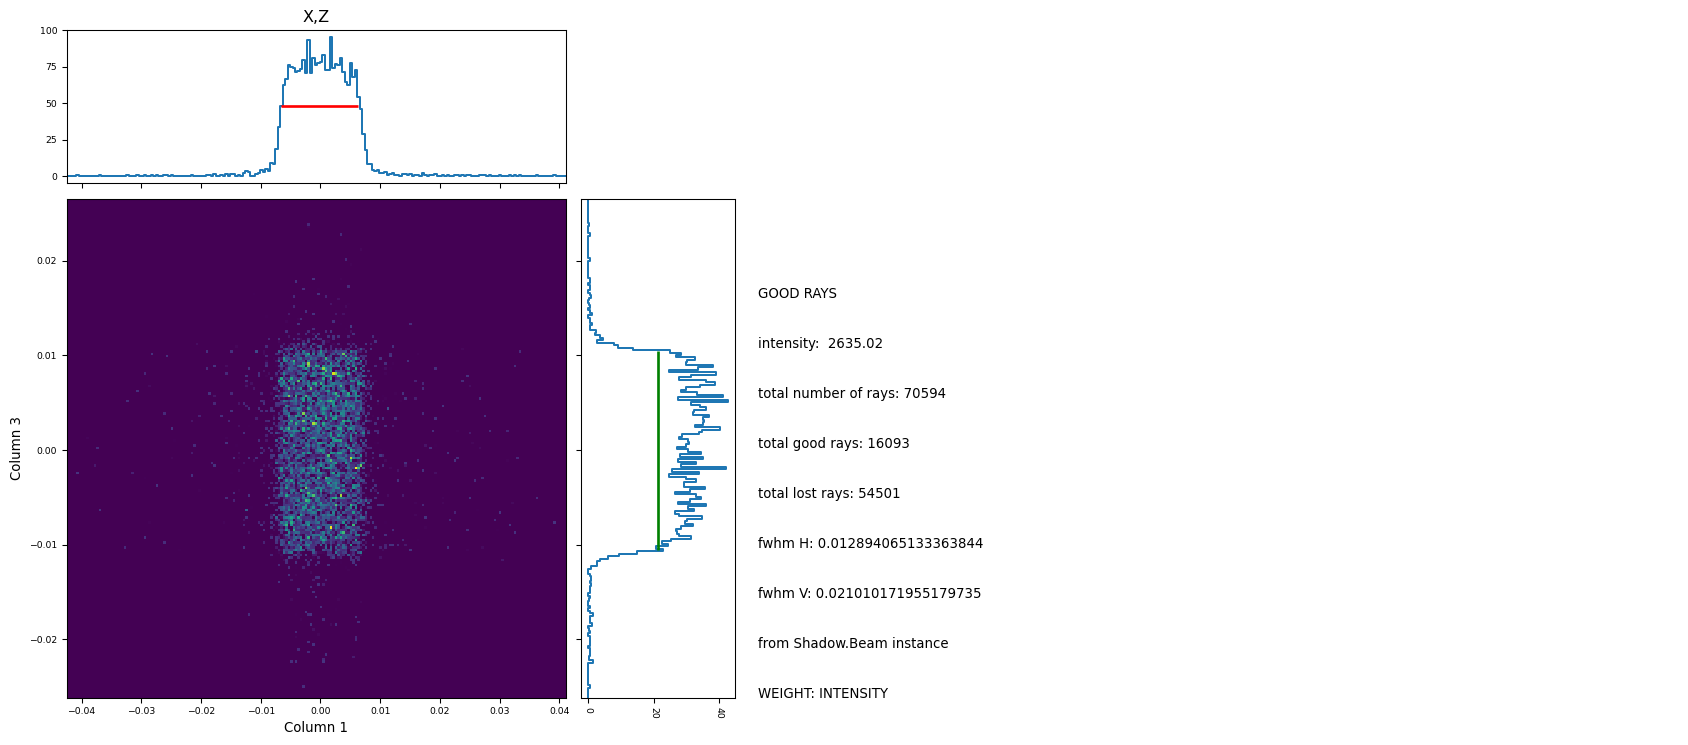

In [16]:
# check positive and negative movement
movers.move_motors(focusing_system, move_motors, [100, 100], movement='relative')
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)
movers.move_motors(focusing_system, move_motors, initial_absolute_positions, movement='absolute')

In [19]:
# Plotting the loss function for a grid of values

In [20]:
move_motors

['vkb_q', 'hkb_q']

In [21]:
test_hkb_q = np.linspace(-100, 100, 6)
test_vkb_q = test_hkb_q
fwhm_values = []
for v in tqdm(test_vkb_q):
    for h in (test_hkb_q):
        focusing_system = movers.move_motors(focusing_system, move_motors, [v, h], movement='relative')
        fwhm, out_beam, *_ = opt_common.get_fwhm(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED)
        focusing_system = movers.move_motors(focusing_system, move_motors, initial_absolute_positions, movement='absolute')
        fwhm_values.append(fwhm)

100%|██████████| 6/6 [01:52<00:00, 18.83s/it]


In [26]:
xvals, yvals

(array([ 20.,  60., 100., 140., 180., 220.]),
 array([121., 161., 201., 241., 281., 321.]))

In [31]:
xx, yy = np.meshgrid(xvals, yvals)

In [33]:
fwhm_values

[0.15106488297111745,
 0.06300348717569818,
 0.0561387368794777,
 0.05598188136659953,
 0.05661840519824087,
 0.057258149305061776,
 0.14259228981613348,
 0.03848896421068455,
 0.025758895905025374,
 0.025415198947745975,
 0.026788152485250374,
 0.028115066762730276,
 0.14050900825787915,
 0.02986002881238963,
 0.008587192906527239,
 0.007493535561295388,
 0.011306009804811197,
 0.014166076716666962,
 0.14046275519951212,
 0.029641616147676384,
 0.007793962563593986,
 0.006569430777282391,
 0.01071588568115086,
 0.01369971101235416,
 0.14103165032000853,
 0.03222989764759525,
 0.014862259908753943,
 0.014258272041672727,
 0.01658225285679149,
 0.01865001309901953,
 0.14185431833210724,
 0.035657924959058694,
 0.02129807729619341,
 0.020881083225997677,
 0.022532031126150775,
 0.02409448726468357]

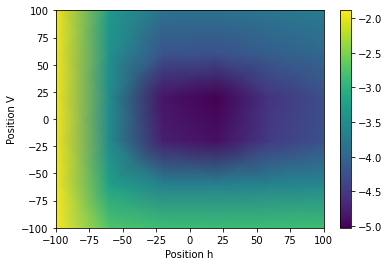

In [43]:
xvals = test_hkb_q + initial_absolute_positions[1]
yvals = test_vkb_q + initial_absolute_positions[0]

#plt.plot(test_values + initial_absolute_positions[0], fwhm_values)
plt.pcolormesh(xx, yy, np.log(np.reshape(fwhm_values, (6,6))), shading='gouraud')
plt.xlabel('Position h')
plt.ylabel('Position V')
plt.colorbar()
plt.show()

In [48]:
%%time
initial_losses = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_losses = []
final_out_beams = []
opt_results_all_scipy = []

min_trans = -100
max_trans = 100

for outer in tqdm(range(1)):
    translations = np.random.uniform(min_trans, max_trans, size=2)
    test_absolute_movements = initial_absolute_positions + translations
    print("Initial motor positions are", test_absolute_movements)
    absolute_movements.append(test_absolute_movements)
    
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    fwhm, out_beam, hist, dw = opt_common.get_fwhm(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    initial_losses.append(fwhm)
    initial_out_beams.append(out_beam)
    
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                              motor_types=move_motors, 
                                              initial_motor_positions=test_absolute_movements, 
                                              random_seed=DEFAULT_RANDOM_SEED,
                                              loss_parameter='fwhm',
                                              default_opt_params={'maxfev':100})
    
    opt_results, guesses, solution, success = opt_trial.trials(verbose=True, guess_min=min_trans, guess_max=max_trans)
    focusing_system = opt_trial.focusing_system
    
    start_guesses.append(guesses)
    overall_successes.append(success)
    fwhm, out_beam, *_ = opt_common.get_fwhm(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    final_losses.append(fwhm)
    final_out_beams.append(out_beam)
    opt_results_all_scipy.append(opt_results)
    print(f'Test {outer} success {success} with final x {opt_results[-1].x} and final value {opt_results[-1].fun}')

  0%|          | 0/1 [00:00<?, ?it/s]

Initial motor positions are [263.91719196  52.51985055]
motors ['vkb_q', 'hkb_q'] trans [0. 0.] current loss 0.038522812072670255
Initial loss is 0.038522812072670255
motors ['vkb_q', 'hkb_q'] trans [20.36615317 37.33210346] current loss 0.017510430808014763
motors ['vkb_q', 'hkb_q'] trans [21.38446083 37.33210346] current loss 0.017774947734353466
motors ['vkb_q', 'hkb_q'] trans [20.36615317 39.19870864] current loss 0.0169708946982478
motors ['vkb_q', 'hkb_q'] trans [19.34784551 39.19870864] current loss 0.01691809461632848
motors ['vkb_q', 'hkb_q'] trans [18.32953785 40.13201122] current loss 0.016251399959589626
motors ['vkb_q', 'hkb_q'] trans [18.32953785 41.9986164 ] current loss 0.01584828121639222
motors ['vkb_q', 'hkb_q'] trans [17.31123019 44.33187286] current loss 0.0156320734340662
motors ['vkb_q', 'hkb_q'] trans [15.27461488 45.26517545] current loss 0.015133850409570345
motors ['vkb_q', 'hkb_q'] trans [12.72884573 48.29840886] current loss 0.01408728638305901
motors ['vkb

100%|██████████| 1/1 [05:21<00:00, 321.25s/it]

Test 0 success True with final x [-45.069749    67.95633177] and final value 0.0011591530003579613
CPU times: user 5min 5s, sys: 36.4 s, total: 5min 42s
Wall time: 5min 21s


In [49]:
opt_results_all_scipy

[[ final_simplex: (array([[-45.069749  ,  67.95633177],
         [-45.06073058,  67.96423374],
         [-45.04384686,  67.95329901]]), array([0.00115915, 0.00115924, 0.00115928]))
             fun: 0.0011591530003579613
         message: 'Maximum number of function evaluations has been exceeded.'
            nfev: 100
             nit: 49
          status: 1
         success: False
               x: array([-45.069749  ,  67.95633177])]]

In [50]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [51]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [52]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [53]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

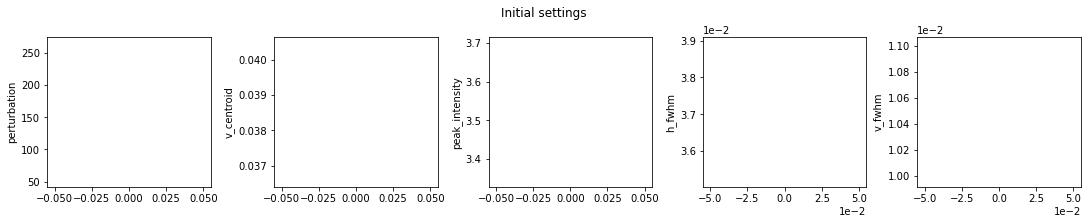

In [54]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_movements)
axes[0].set_ylabel('perturbation')

axes[1].plot(initial_losses)
axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/initial_metrics.png', bbox_inches='tight')

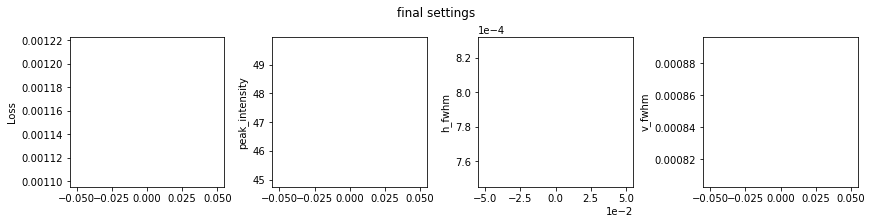

In [55]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

axes[0].plot(final_losses)
axes[0].set_ylabel('Loss')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/final_metrics.png', bbox_inches='tight')

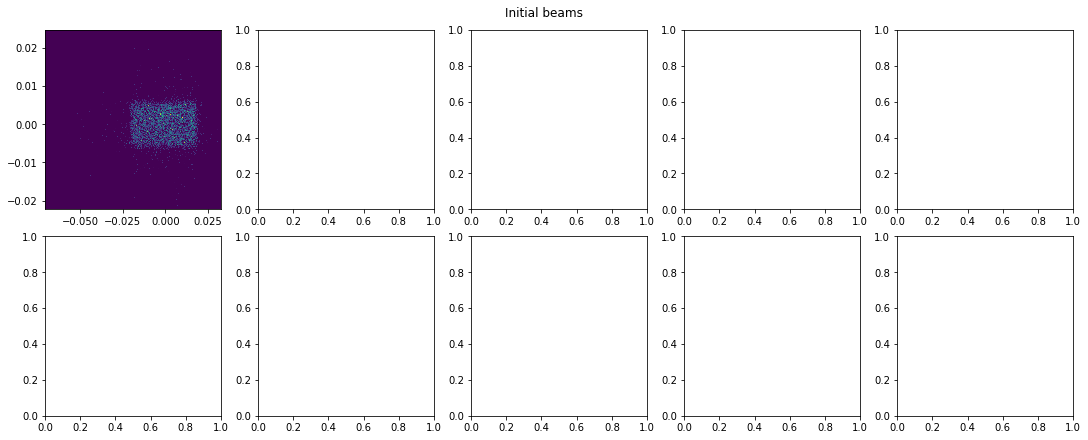

In [56]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/initial_beams.png', bbox_inches='tight')

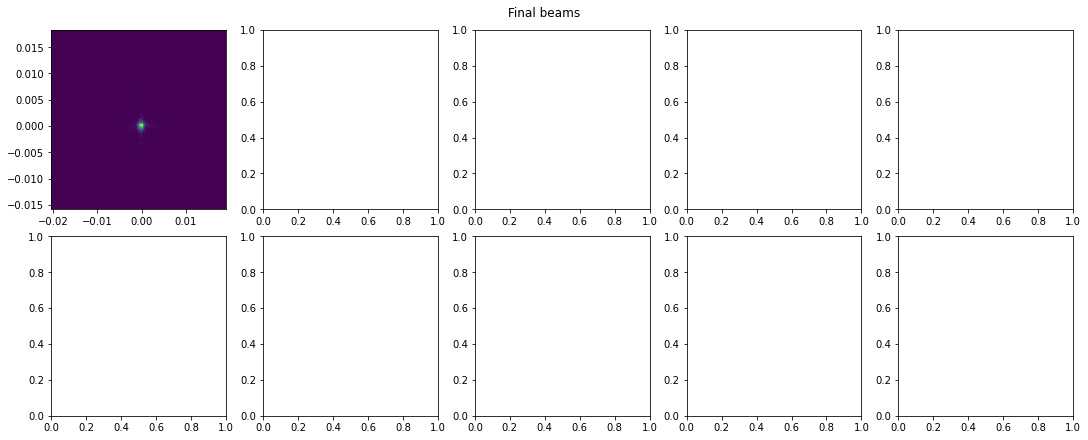

In [57]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/final_beams.png', bbox_inches='tight')

In [17]:
# Test gaussian process optimization

In [18]:
import skopt

In [19]:
callback_y = skopt.callbacks.DeltaYStopper(1e-3)
callback_x = skopt.callbacks.DeltaXStopper(1e-1)

In [21]:
%%time
initial_losses = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_losses = []
final_out_beams = []
opt_results_all_gp = []

min_trans = -100.
max_trans = 100.

for outer in tqdm(range(10)):
    translations = np.random.uniform(min_trans, max_trans, size=1)
    test_absolute_movements = initial_absolute_positions + translations
    print("Initial motor positions are", test_absolute_movements)
    absolute_movements.append(test_absolute_movements)
    
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    fwhm, out_beam, hist, dw = opt_common.get_fwhm(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    initial_losses.append(fwhm)
    initial_out_beams.append(out_beam)
    
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                              motor_types=move_motors, 
                                              initial_motor_positions=test_absolute_movements, 
                                              random_seed=DEFAULT_RANDOM_SEED,
                                              loss_parameter='fwhm')
    opt_trial.set_gaussian_process_optimizer(bounds=[[min_trans, max_trans], [min_trans, max_trans]], 
                                                     callback=[callback_x, callback_y])
    
    opt_results, guesses, solution, success = opt_trial.trials(verbose=True, guess_min=0., guess_max=0.0)
    focusing_system = opt_trial.focusing_system
    
    start_guesses.append(guesses)
    overall_successes.append(success)
    fwhm, out_beam, *_ = opt_common.get_fwhm(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    if opt_results[-1].fun == 0:
        plot_s
    
    
    final_losses.append(fwhm)
    final_out_beams.append(out_beam)
    opt_results_all_gp.append(opt_results)
    print(f'Test {outer} success {success} with final x {opt_results[-1].x} and final value {opt_results[-1].fun}')

  0%|          | 0/10 [00:00<?, ?it/s]

Initial motor positions are [134.62188708  33.62188708]
motors ['vkb_q', 'hkb_q'] trans [0. 0.] current loss 0.08681034539245913
Initial loss is 0.08681034539245913
motors ['vkb_q', 'hkb_q'] trans [91.62976572 24.00802345] current loss 0.03194053757514301
motors ['vkb_q', 'hkb_q'] trans [ -7.95641785 -24.08542899] current loss 0.2405895886492268
motors ['vkb_q', 'hkb_q'] trans [-69.3311169   85.66896773] current loss 0.1646058977940252
motors ['vkb_q', 'hkb_q'] trans [  6.58240616 -40.39144119] current loss 10000.0
motors ['vkb_q', 'hkb_q'] trans [61.75807607 49.87759493] current loss 0.015136397142731906
motors ['vkb_q', 'hkb_q'] trans [-59.255862    89.37441474] current loss 0.13338721866452077


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID


motors ['vkb_q', 'hkb_q'] trans [ 63.59022504 -27.25624074] current loss 0.005763300636785429
motors ['vkb_q', 'hkb_q'] trans [-89.00695811 -86.91755557] current loss 10000.0
motors ['vkb_q', 'hkb_q'] trans [-72.38219619  -3.44473767] current loss 0.19520687475363344
motors ['vkb_q', 'hkb_q'] trans [-86.87598234   7.00756144] current loss 0.2557472645461058
motors ['vkb_q', 'hkb_q'] trans [99.45745227 66.20196105] current loss 0.006855713268523683
motors ['vkb_q', 'hkb_q'] trans [ 63.42141915 -26.78396876] current loss 0.007666349070255166
motors ['vkb_q', 'hkb_q'] trans [ 54.93730046 -26.51266313] current loss 0.5470550401012436
motors ['vkb_q', 'hkb_q'] trans [ 59.67830503 -26.87688599] current loss 0.7925370980852658
motors ['vkb_q', 'hkb_q'] trans [-42.73745712 -23.58499044] current loss 0.2616405279549498
motors ['vkb_q', 'hkb_q'] trans [ 60.52674974 -26.81207653] current loss 0.6011101090339892
motors ['vkb_q', 'hkb_q'] trans [ 60.62070636 -26.81587779] current loss 0.34656825911

 10%|█         | 1/10 [03:37<32:38, 217.59s/it]

Test 0 success True with final x [100.0, 89.06279891386905] and final value 0.0037973098765473577
Initial motor positions are [244.97832235 143.97832235]
motors ['vkb_q', 'hkb_q'] trans [0. 0.] current loss 0.00777292678610477
Initial loss is 0.00777292678610477
motors ['vkb_q', 'hkb_q'] trans [58.81503416 70.85820901] current loss 0.021976010247075847
motors ['vkb_q', 'hkb_q'] trans [-31.91178653 -16.8698901 ] current loss 0.0030568698204581374
motors ['vkb_q', 'hkb_q'] trans [-2.89792137  0.89745772] current loss 0.0073126131692876324
motors ['vkb_q', 'hkb_q'] trans [ 12.58589582 -82.9283273 ] current loss 0.030039597827317133
motors ['vkb_q', 'hkb_q'] trans [-69.38864402 -20.25467391] current loss 0.01759496819934611
motors ['vkb_q', 'hkb_q'] trans [  0.18525975 -84.89755459] current loss 0.03099714828415124
motors ['vkb_q', 'hkb_q'] trans [-30.14332097 -15.83897089] current loss 0.0026084595610449
motors ['vkb_q', 'hkb_q'] trans [  9.18585601 -80.23639532] current loss 0.0274958250

 20%|██        | 2/10 [05:52<22:33, 169.16s/it]

Test 1 success True with final x [-25.432304503001063, -27.47342639693801] and final value 0.0013755040221567524
Initial motor positions are [303.20549697 202.20549697]
motors ['vkb_q', 'hkb_q'] trans [0. 0.] current loss 0.021432553307984027
Initial loss is 0.021432553307984027
motors ['vkb_q', 'hkb_q'] trans [-50.7977713   46.18490754] current loss 0.016840320295624746
motors ['vkb_q', 'hkb_q'] trans [-3.67030696 41.88326818] current loss 0.02275926834400362
motors ['vkb_q', 'hkb_q'] trans [-57.50750044 -58.8237235 ] current loss 0.007770675525732707
motors ['vkb_q', 'hkb_q'] trans [96.91034489 91.72670975] current loss 0.03457428886576351
motors ['vkb_q', 'hkb_q'] trans [ 31.54821262 -34.00703099] current loss 0.02396258615391543
motors ['vkb_q', 'hkb_q'] trans [-38.52576778 -19.52771067] current loss 0.01455753482750166
motors ['vkb_q', 'hkb_q'] trans [-77.8320151  -43.54599307] current loss 0.0069080406005173015
motors ['vkb_q', 'hkb_q'] trans [98.15031698 38.98746075] current los

 30%|███       | 3/10 [07:53<17:10, 147.18s/it]

Test 2 success True with final x [-83.79146798353975, -82.30344998718924] and final value 0.001286087686378159
Initial motor positions are [290.13009548 189.13009548]
motors ['vkb_q', 'hkb_q'] trans [0. 0.] current loss 0.01867985014665032
Initial loss is 0.01867985014665032
motors ['vkb_q', 'hkb_q'] trans [-75.78254224  28.20972077] current loss 0.012530632438752236
motors ['vkb_q', 'hkb_q'] trans [ 3.90925845 60.47863358] current loss 0.021860702507524366
motors ['vkb_q', 'hkb_q'] trans [86.35745111 23.78312467] current loss 0.030321650892403386
motors ['vkb_q', 'hkb_q'] trans [-65.87770586  -2.40298099] current loss 0.010298961201735925
motors ['vkb_q', 'hkb_q'] trans [84.08749878 -5.81717574] current loss 0.028994846578704905
motors ['vkb_q', 'hkb_q'] trans [  0.93236229 -89.3019546 ] current loss 0.017127891941498993
motors ['vkb_q', 'hkb_q'] trans [-97.52841505 -79.7990355 ] current loss 0.010113561581365347
motors ['vkb_q', 'hkb_q'] trans [ 93.41780504 -49.18043686] current loss

 40%|████      | 4/10 [10:13<14:25, 144.33s/it]

Test 3 success True with final x [-69.5172601433464, -69.62204868771609] and final value 0.0012826947949566973
Initial motor positions are [231.97029552 130.97029552]
motors ['vkb_q', 'hkb_q'] trans [0. 0.] current loss 0.003835380833961323
Initial loss is 0.003835380833961323
motors ['vkb_q', 'hkb_q'] trans [ 70.88526143 -75.1969699 ] current loss 0.03825796178242242
motors ['vkb_q', 'hkb_q'] trans [-81.37809919  48.09504413] current loss 0.033189786699881665
motors ['vkb_q', 'hkb_q'] trans [ 56.52900142 -30.90697534] current loss 0.016483675425891263
motors ['vkb_q', 'hkb_q'] trans [ 51.02777609 -88.18333975] current loss 0.055306925432236746
motors ['vkb_q', 'hkb_q'] trans [ 13.00841865 -67.12998454] current loss 0.026716905405995868
motors ['vkb_q', 'hkb_q'] trans [-89.34298902  34.24785203] current loss 0.03843712887018016
motors ['vkb_q', 'hkb_q'] trans [-50.43354832 -39.01831462] current loss 0.016983970847885235
motors ['vkb_q', 'hkb_q'] trans [ 92.96977655 -83.49357947] curren

 50%|█████     | 5/10 [11:59<10:51, 130.23s/it]

Test 4 success True with final x [-7.849677504166181, -8.296910060974412] and final value 0.0014514991929438393
Initial motor positions are [190.64120857  89.64120857]
motors ['vkb_q', 'hkb_q'] trans [0. 0.] current loss 0.014698737617386411
Initial loss is 0.014698737617386411
motors ['vkb_q', 'hkb_q'] trans [-98.05113759 -34.84094342] current loss 0.10212184222193844
motors ['vkb_q', 'hkb_q'] trans [-22.1003188   81.78164672] current loss 0.022783491124784238
motors ['vkb_q', 'hkb_q'] trans [ 67.3166244  -23.99299431] current loss 0.026391137626056497
motors ['vkb_q', 'hkb_q'] trans [ 32.34000368 -27.83770887] current loss 0.027886195874927498
motors ['vkb_q', 'hkb_q'] trans [-80.80693759  25.00950789] current loss 0.06991361429620663
motors ['vkb_q', 'hkb_q'] trans [-40.88090104  18.33256001] current loss 0.03236362834257425
motors ['vkb_q', 'hkb_q'] trans [45.68547439 -7.12550154] current loss 0.013846885589645539
motors ['vkb_q', 'hkb_q'] trans [-92.3662571   62.69143411] current 

 60%|██████    | 6/10 [14:59<09:48, 147.15s/it]

Test 5 success True with final x [37.73361753139085, 40.40183843697832] and final value 0.0028225601983541612
Initial motor positions are [242.46318061 141.46318061]
motors ['vkb_q', 'hkb_q'] trans [0. 0.] current loss 0.006873356493461455
Initial loss is 0.006873356493461455
motors ['vkb_q', 'hkb_q'] trans [-11.58156871 -64.13665146] current loss 0.016332879120218243
motors ['vkb_q', 'hkb_q'] trans [ -7.07800765 -86.48135255] current loss 0.03520809032913798
motors ['vkb_q', 'hkb_q'] trans [74.07448749 -2.81658225] current loss 0.02047082767147087
motors ['vkb_q', 'hkb_q'] trans [-68.65775603 -21.58392056] current loss 0.018614450328195514
motors ['vkb_q', 'hkb_q'] trans [ 55.75105368 -50.56876861] current loss 0.019692441300201945
motors ['vkb_q', 'hkb_q'] trans [51.88343761 33.77879574] current loss 0.018612574763850014
motors ['vkb_q', 'hkb_q'] trans [ 93.29131462 -64.44626959] current loss 0.027880417833422003
motors ['vkb_q', 'hkb_q'] trans [-63.62312871 -93.80108408] current los

 70%|███████   | 7/10 [17:12<07:07, 142.53s/it]

Test 6 success True with final x [-21.237835218782564, -21.20267919514626] and final value 0.0012916283177496816
Initial motor positions are [241.66746274 140.66746274]
motors ['vkb_q', 'hkb_q'] trans [0. 0.] current loss 0.00668170194277756
Initial loss is 0.00668170194277756
motors ['vkb_q', 'hkb_q'] trans [-30.42244512 -79.96344005] current loss 0.028884760755634974
motors ['vkb_q', 'hkb_q'] trans [ 65.76173196 -84.19026691] current loss 0.03790778701134154
motors ['vkb_q', 'hkb_q'] trans [-3.28325338 18.60232885] current loss 0.008117182137046864
motors ['vkb_q', 'hkb_q'] trans [ 86.35073116 -19.6480611 ] current loss 0.022060295363957396
motors ['vkb_q', 'hkb_q'] trans [73.915692   48.22809383] current loss 0.022606943558732568
motors ['vkb_q', 'hkb_q'] trans [-16.48402838  81.60064475] current loss 0.01306411288003642
motors ['vkb_q', 'hkb_q'] trans [ 21.04954775 -35.40600794] current loss 0.011176181306165855
motors ['vkb_q', 'hkb_q'] trans [-79.63285327  -2.57750808] current lo

 80%|████████  | 8/10 [19:54<04:57, 148.97s/it]

Test 7 success True with final x [-20.03127943565255, -18.850013207063583] and final value 0.00117953708505793
Initial motor positions are [245.50206458 144.50206458]
motors ['vkb_q', 'hkb_q'] trans [0. 0.] current loss 0.007951668611414246
Initial loss is 0.007951668611414246
motors ['vkb_q', 'hkb_q'] trans [-18.16788104  69.69539525] current loss 0.012384165331337793
motors ['vkb_q', 'hkb_q'] trans [ 4.35186978 36.99106949] current loss 0.011851931398200947
motors ['vkb_q', 'hkb_q'] trans [54.68086974 67.68259417] current loss 0.021291132567056267
motors ['vkb_q', 'hkb_q'] trans [-42.82574531 -41.06933921] current loss 0.007553314873115905
motors ['vkb_q', 'hkb_q'] trans [73.7388054  33.11743018] current loss 0.022288762350239737
motors ['vkb_q', 'hkb_q'] trans [-14.10138477  -3.87108986] current loss 0.004729058606318065
motors ['vkb_q', 'hkb_q'] trans [-96.55479476  59.44936755] current loss 0.035071770264747865
motors ['vkb_q', 'hkb_q'] trans [-40.4791844    0.07051418] current lo

 90%|█████████ | 9/10 [21:49<02:18, 138.10s/it]

Test 8 success True with final x [-24.279488141141783, -23.688829409766456] and final value 0.0012978390064714092
Initial motor positions are [261.07892407 160.07892407]
motors ['vkb_q', 'hkb_q'] trans [0. 0.] current loss 0.012055735308051171
Initial loss is 0.012055735308051171
motors ['vkb_q', 'hkb_q'] trans [ 31.84998487 -74.33717757] current loss 0.019766063166461033
motors ['vkb_q', 'hkb_q'] trans [-33.9323621  -97.64554134] current loss 0.027381773679481754
motors ['vkb_q', 'hkb_q'] trans [-18.48785952 -98.06898909] current loss 0.028167096773040898
motors ['vkb_q', 'hkb_q'] trans [-16.04042538  28.26609093] current loss 0.011994194624233673
motors ['vkb_q', 'hkb_q'] trans [-37.6326905    0.89303532] current loss 0.006962492228436835
motors ['vkb_q', 'hkb_q'] trans [-81.81805983  24.76796901] current loss 0.0185613644302893
motors ['vkb_q', 'hkb_q'] trans [14.07277864 41.24214351] current loss 0.01713735102370328
motors ['vkb_q', 'hkb_q'] trans [ 89.37485308 -47.44804925] curren

100%|██████████| 10/10 [23:46<00:00, 142.66s/it]

Test 9 success True with final x [-40.21361636758651, -39.89598311761081] and final value 0.0012904858205330257
CPU times: user 27min 49s, sys: 39min 25s, total: 1h 7min 14s
Wall time: 23min 46s


In [22]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [23]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [24]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [25]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

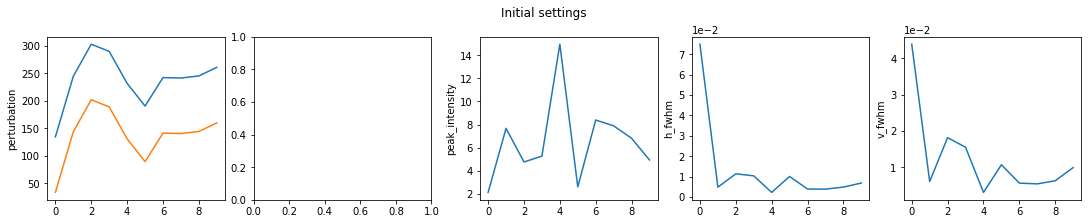

In [27]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_movements)
axes[0].set_ylabel('perturbation')

#axes[1].plot(initial_centroids)
#axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/initial_metrics.png', bbox_inches='tight')

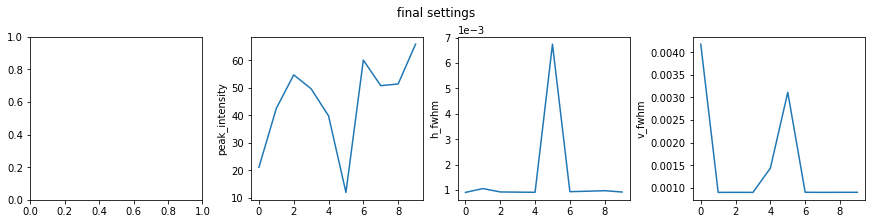

In [28]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

#axes[0].plot(final_centroids)
#axes[0].set_ylabel('v_centroid')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/final_metrics.png', bbox_inches='tight')

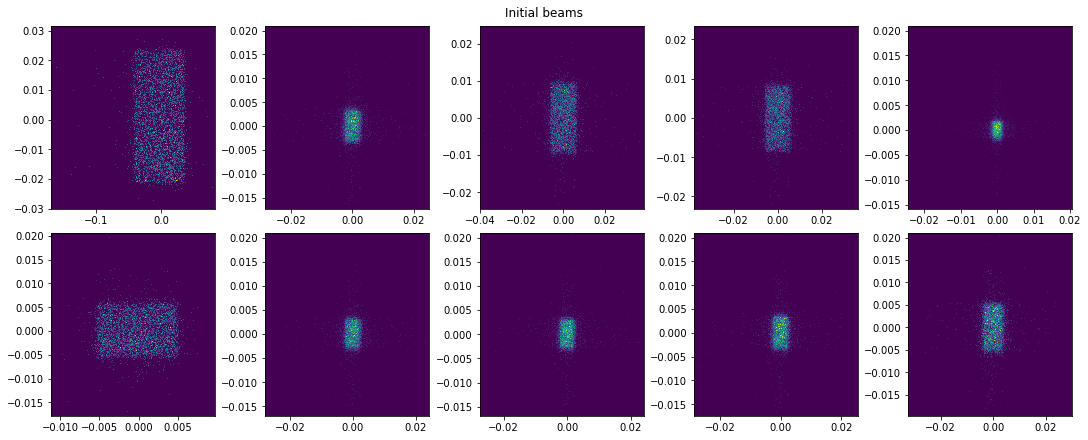

In [30]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/initial_beams.png', bbox_inches='tight')

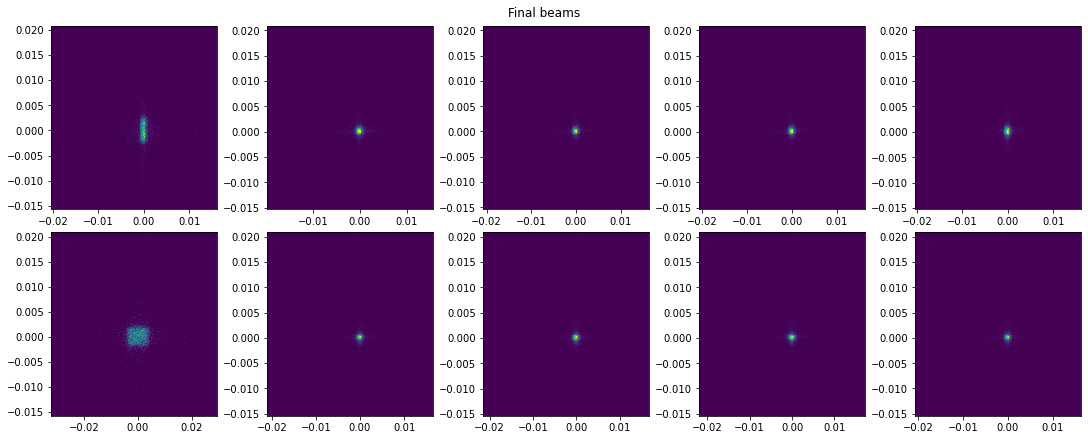

In [31]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/final_beams.png', bbox_inches='tight')

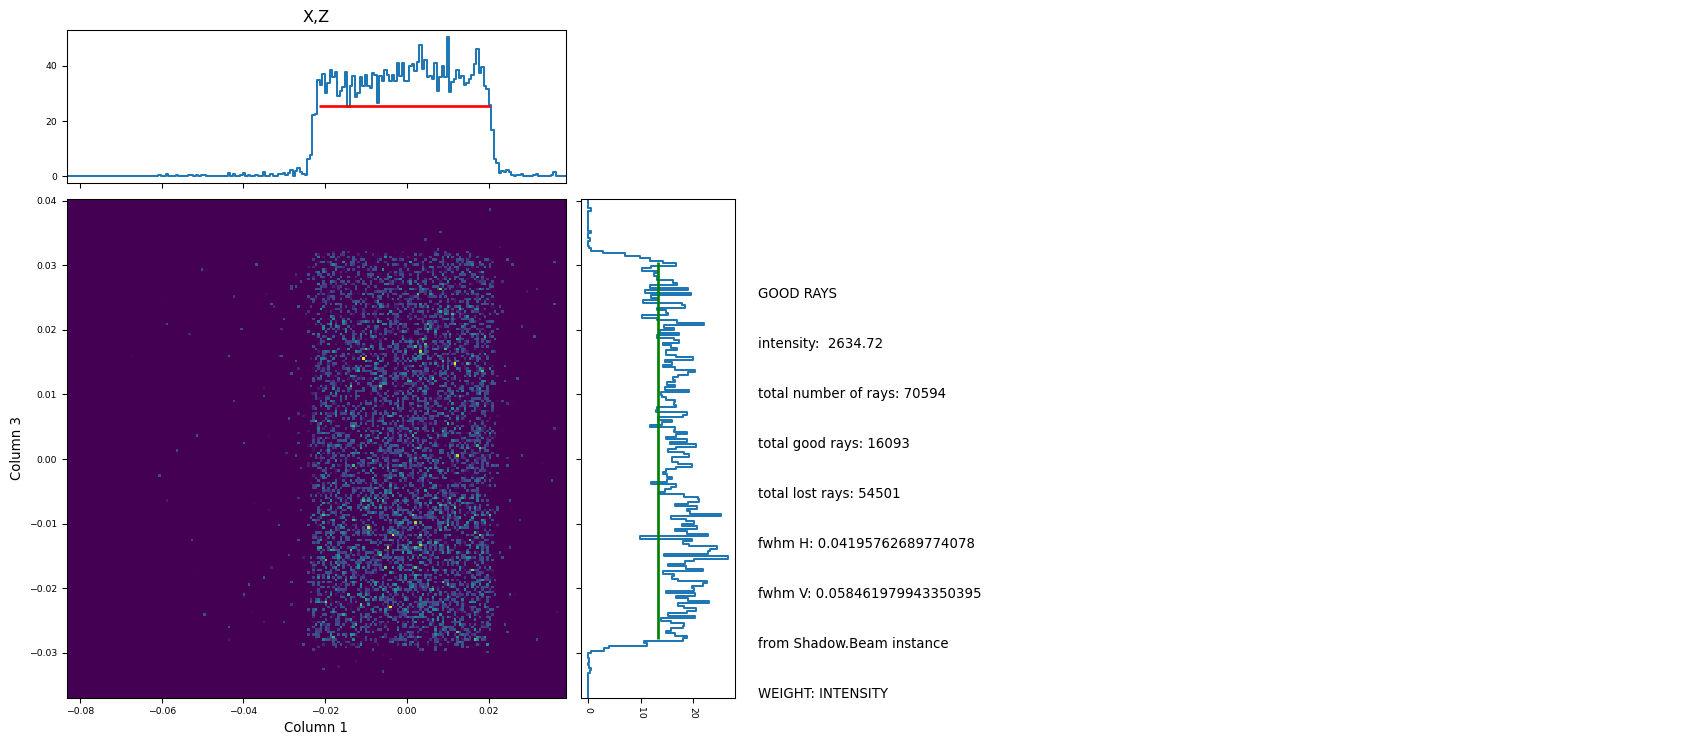

In [74]:
_ = plot_shadow_beam_spatial_distribution(final_out_beams[0])

In [76]:
(0.04**2 + 0.06**2)**0.5

0.07211102550927978

In [25]:
clean_up()

In [26]:
shutil.rmtree(temp_work_dir)